In [29]:
import torch
import numpy as np
import os
import cma
from gan.config import SmallModelConfig
from gan.small_models import Generator
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import LevelVisualizer
from gan.env import Env
from PIL import Image

In [30]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_dim=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters
).to(device)
env = Env(config.env_name,config.env_version)
level_visualizer = LevelVisualizer(env=env)

model_path = os.path.join(
    "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/none-804", "models.tar")
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


device : cpu


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=341146, Tue Aug 23 04:34:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -2.190000000000000e+02 1.0e+00 1.89e-01  2e-01  2e-01 0:02.0
    2     28 -2.190000000000000e+02 1.1e+00 1.83e-01  2e-01  2e-01 0:04.0
    3     42 -2.190000000000000e+02 1.1e+00 1.76e-01  2e-01  2e-01 0:06.0
    5     70 -2.190000000000000e+02 1.1e+00 1.67e-01  2e-01  2e-01 0:09.8
    7     98 -2.190000000000000e+02 1.2e+00 1.55e-01  2e-01  2e-01 0:13.6
INIT:  [-0.88928032  0.96914476 -0.34834355 -0.86618769 -0.42930919  0.32557756
 -0.24475083  1.03999925  0.34102684  0.25058523 -0.66816002 -1.72397912
  0.76984143  0.54592729  0.11986626  2.53826118 -1.12517715  0.11838826
 -1.53594744 -1.23557377 -0.7874409  -0.11955765 -1.85419357  0.82836473
  0.48533484 -0.67491305  0.65896004  0.93355435  1.18376148  0.74227798
  0.02775931 -0.39037022]
BEST:  [-1.04988618  1.1814367  -0.54762955 -0.7599787  -0.36429638 

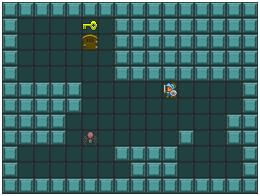

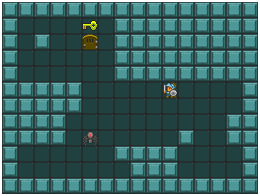

In [31]:
def eval(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + enemy*10


def fitness(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0])
    ev = eval(level_str)
    return -(playable*100 + ev)

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()

es = cma.CMAEvolutionStrategy(x.tolist(), 0.2)
es.optimize(fitness)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitness(best))

show(x)
show(torch.FloatTensor(best))
